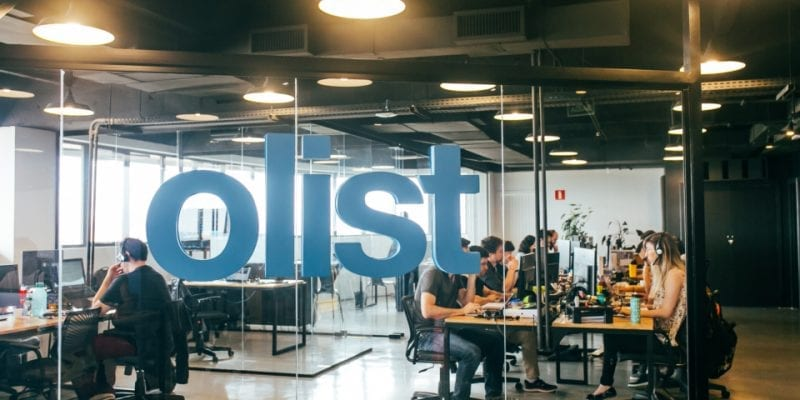

# Brazilian E-Commerce Olist Customers Segmentation

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

In [983]:
# ! usr/bin/env python 3
# coding: utf-8

# Importing librairies

from sklearn.preprocessing import StandardScaler
from IPython.display import HTML
import numpy as np               # numerical data processing
import pandas as pd              # numerical tables & time series
import scipy as sp
# numerical integration, interpolation, optimization and statistics
import scipy.stats as st         # statistical functions
import seaborn as sns            # statistical data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# static, animated, and interactive visualizations in Python
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import time
from sklearn import preprocessing
# import warnings
# warnings.filterwarnings('ignore')
# %load_ext pycodestyle_magic
# %pycodestyle_on

__FONCTION DEFINED TO HELP DESCRIBING THE CHARACTERISTICS OF THE INPUT FILES__

In [984]:
def duplicates(data):
    """Calculate the number of duplicates in dataframe data"""

    return len(data)-len(data.drop_duplicates())


def missing_cells(data):
    """Calculate the number of empty cells in dataframe data"""

    return data.isna().sum().sum()


def missing_cells_percent(data):
    """Calculate the percentage of empty cells in dataframe data"""

    return missing_cells(data)/(data.size)*100


def filled_cells(data):
    """Calculate the number of existing values in dataframe data"""

    return data.notna().sum()


def filled_cells_percent(data):
    """Calculate the percentage of existing values in dataframe data"""

    return filled_cells(data)/(len(data.index))*100

In [985]:
# Transforming our input files.csv from the cleaning phase to dataframe

customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
translation = pd.read_csv("product_category_name_translation.csv")

## 1. INPUT FILES OVERVIEW 

### 1.1 CUSTOMERS

In [986]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [987]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.

__customer_unique_id__：Customer ID number<br>
__customer_zip_code_prefix__：Zip code of customer<br>
__customer_city__：City of customer<br>
__customer_state__：State of customer<br>
__seller_zip_code_prefix__：Zip code of seller<br>
__seller_city__：City of seller<br>
__seller_state__：State of seller<br>

At our system each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.

### 1.2 GEOLOCATION

In [988]:
geolocation.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [989]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


This dataset has information Brazilian zip codes and its lat/lng coordinates.

### 1.3 ORDER ITEMS

In [990]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [991]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


This dataset includes data about the items purchased within each order.

__order_item_id__：The number of the product in the order (ex：If there are three items in the order, the order_item_id is 1, 2, 3)<br>
__product_id__：Product ID number<br>
__seller_id__：Seller ID number<br>
__shipping_limit_date__：The deadline for the seller to deliver the goods to the logistics<br>
__price__：Product price<br>
__freight_value__：delivery fee<br>

### 1.4 ORDER PAYMENTS

In [992]:
order_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


This dataset includes data about the orders payment options.

__payment_sequential__: Number of different ways to pay<br>
__payment_type__: Way of paying<br>
__payment_installments__: Number of installments<br>
__payment_value__: Value of the transaction<br>

### 1.5 ORDER REVIEWS

In [993]:
order_reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [994]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


This dataset includes data about the reviews made by the customers.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

__review_id__：The comment ID number<br>
__review_score__：Customer satisfaction<br>
__review_comment_title__：Comment title<br>
__review_comment_message__：Comment message<br>
__review_creation_date__：Time of inviteing customer make a comment<br>
__review_answer_timestamp__：Time of customer finish the comment<br>

### 1.6 ORDERS

In [995]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [996]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


This is the core dataset. From each order you might find all other information.<br>

__order_id__：Order ID number<br>
__customer_id__： Customer ID number<br>
__order_status__：Status of order progress<br>
__order_purchase_timestamp__：Time of order<br>
__order_approved_at__：Time of payment for the order<br>
__order_delivered_carrier_date__：Time of notifying the logistics in order process<br>
__order_delivered_customer_date__：Time of the product arrived at the consumer<br>
__order_estimated_delivery_date__：Estimated arrival time of the order<br>

### 1.7 TRANSLATION

In [997]:
translation.head(2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


Translates the product/category name to english.

### 1.8 PRODUCTS

In [998]:
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


This dataset includes data about the products sold by Olist.

__product_category_name__：Product category<br>
__product_name_lenght__：Number of words in product name<br>
__product_description_lenght__：Number of words in product description<br>
__product_photos_qty__：Number of product photo<br>
__product_weight_g__：Weight of product（grams)<br>
__product_length_cm__：Length of product (centimeter)<br>
__product_height_cm__：Height of product（centimeter）<br>
__product_width_cm__：Width of product（centimeter）<br>

In [999]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


### 1.9 SELLERS

In [1000]:
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [1001]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


This dataset includes data about the sellers that fulfilled orders made at Olist.

### 1.10 SUMMARY

In [1002]:
# INITIALISE FILES_SPEC TO SERIES DICTIONARY

list_files = ["olist_customers_dataset.csv",
              "olist_geolocation_dataset.csv",
              "olist_order_items_dataset.csv",
              "olist_order_payments_dataset.csv",
              "olist_order_reviews_dataset.csv",
              "olist_orders_dataset.csv",
              "olist_products_dataset.csv",
              "olist_sellers_dataset.csv",
              "product_category_name_translation.csv"]

files_spec = {'Total rows': pd.Series([len(customers),
                                       len(geolocation),
                                       len(order_items),
                                       len(order_payments),
                                       len(order_reviews),
                                       len(orders),
                                       len(products),
                                       len(sellers),
                                       len(translation)],
                                      index=list_files),
              'Total columns': pd.Series([len(customers.columns),
                                          len(geolocation.columns),
                                          len(order_items.columns),
                                          len(order_payments.columns),
                                          len(order_reviews.columns),
                                          len(orders.columns),
                                          len(products.columns),
                                          len(sellers.columns),
                                          len(translation.columns)],
                                         index=list_files),
              'Total duplicates': pd.Series([duplicates(customers),
                                             duplicates(geolocation),
                                             duplicates(order_items),
                                             duplicates(order_payments),
                                             duplicates(order_reviews),
                                             duplicates(orders),
                                             duplicates(products),
                                             duplicates(sellers),
                                             duplicates(translation)],
                                            index=list_files),
              'Total Missing cells': pd.Series([missing_cells(customers),
                                                missing_cells(geolocation),
                                                missing_cells(order_items),
                                                missing_cells(order_payments),
                                                missing_cells(order_reviews),
                                                missing_cells(orders),
                                                missing_cells(products),
                                                missing_cells(sellers),
                                                missing_cells(translation)],
                                               index=list_files),
              'Missing cells (%)': pd.Series([missing_cells_percent
                                              (customers),
                                              missing_cells_percent
                                              (geolocation),
                                              missing_cells_percent
                                              (order_items),
                                              missing_cells_percent
                                              (order_payments),
                                              missing_cells_percent
                                              (order_reviews),
                                              missing_cells_percent
                                              (orders),
                                              missing_cells_percent
                                              (products),
                                              missing_cells_percent
                                              (sellers),
                                              missing_cells_percent
                                              (translation)],
                                             index=list_files)}

# Creates Dataframe df_files_spec

df_files_spec = pd.DataFrame(files_spec)
index = df_files_spec.index
index.name = "Input File Name"
round(df_files_spec, 2)

,Total rows,Total columns,Total duplicates,Total Missing cells,Missing cells (%)
Input File Name,,,,,
olist_customers_dataset.csv,99441,5,0,0,0.00
olist_geolocation_dataset.csv,1000163,5,261831,0,0.00
olist_order_items_dataset.csv,112650,7,0,0,0.00
olist_order_payments_dataset.csv,103886,5,0,0,0.00
olist_order_reviews_dataset.csv,99224,7,0,145903,21.01
olist_orders_dataset.csv,99441,8,0,4908,0.62
olist_products_dataset.csv,32951,9,0,2448,0.83
olist_sellers_dataset.csv,3095,4,0,0,0.00
product_category_name_translation.csv,71,2,0,0,0.00


## 2. DATAFRAMES CONNECTION

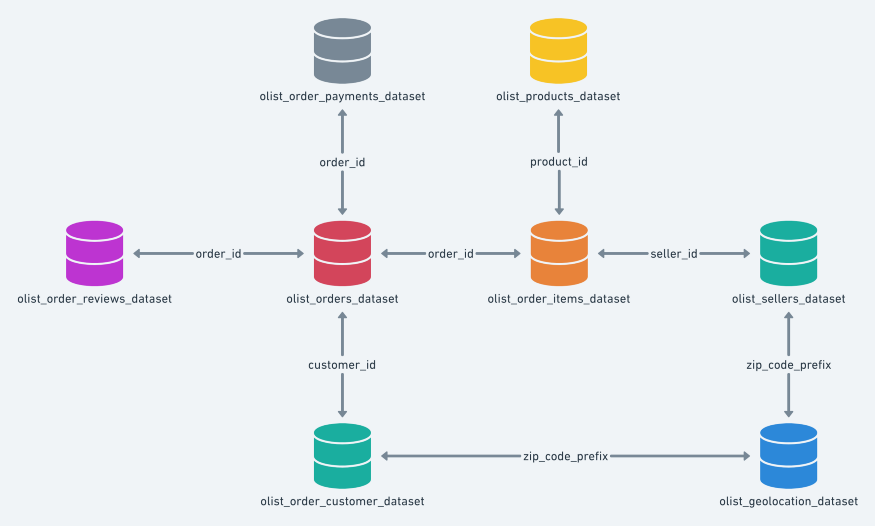

### 2. EXPLORATION OF SELECTED DATAFRAME

#### 2.1 CATEGORY PRODUCTS & TRANSLATION

The category products have the products name in brazilian while the category Translation have them in English. Let's start merging both dataframes and only keep the products categories in english.

In [1003]:
prod_eng = pd.merge(translation, products,
                    on='product_category_name')

# We drop the product category name in portuguese to work with the english one
prod_eng = prod_eng.drop('product_category_name',
                         axis=1)
prod_eng.head(2)

,product_category_name_english,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,health_beauty,e3e020af31d4d89d2602272b315c3f6e,58.0,1987.0,3.0,75.0,21.0,7.0,13.0
1,health_beauty,c5d8079278e912d7e3b6beb48ecb56e8,60.0,330.0,1.0,1300.0,19.0,28.0,17.0


Let's have a look at what is purchased on Olist.

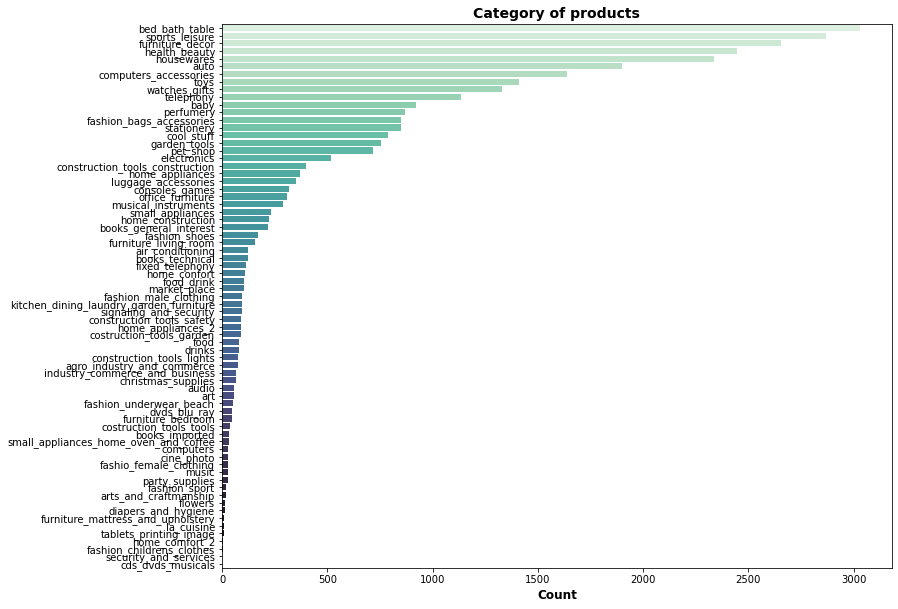

In [1004]:
prod_eng['product_category_name_english'].value_counts()
fig = plt.figure(figsize=(12, 10))
ax = sns.countplot(y=prod_eng['product_category_name_english'],
                   palette='mako_r',
                   order=prod_eng['product_category_name_english']
                   .value_counts().index)
plt.title('Category of products', weight='bold', size=14)
plt.ylabel('')
plt.xlabel('Count', weight='bold', size=12)
plt.show()

We can reference 71 different categories and there are lots of redundant ones that can be regrouped together. By creating a dictionnary, we can see better the main groups of items and it might be more practical for future encoding. Doing that reduces the number of categories from 71 to 11.

In [1005]:
product_cat_dict = {
    'construction_tools_construction': 'construction',
    'construction_tools_lights': 'construction',
    'construction_tools_safety': 'construction',
    'costruction_tools_garden': 'construction',
    'costruction_tools_tools': 'construction',
    'garden_tools': 'construction',
    'home_construction': 'construction',

    'fashio_female_clothing': 'fashion',
    'fashion_bags_accessories': 'fashion',
    'fashion_childrens_clothes': 'fashion',
    'fashion_male_clothing': 'fashion',
    'fashion_shoes': 'fashion',
    'fashion_sport': 'fashion',
    'fashion_underwear_beach': 'fashion',

    'furniture_bedroom': 'furniture',
    'furniture_decor': 'furniture',
    'furniture_living_room': 'furniture',
    'furniture_mattress_and_upholstery': 'furniture',
    'bed_bath_table': 'furniture',
    'kitchen_dining_laundry_garden_furniture': 'furniture',
    'office_furniture': 'furniture',

    'home_appliances': 'home',
    'home_appliances_2': 'home',
    'home_comfort_2': 'home',
    'home_confort': 'home',
    'air_conditioning': 'home',
    'housewares': 'home',
    'art': 'home',
    'arts_and_craftmanship': 'home',
    'flowers': 'home',
    'cool_stuff': 'home',

    'drinks': 'food_drink',
    'food': 'food_drink',
    'food_drink': 'food_drink',
    'la_cuisine': 'food_drink',

    'electronics': 'electronics',
    'audio': 'electronics',
    'tablets_printing_image': 'electronics',
    'telephony': 'electronics',
    'fixed_telephony': 'electronics',
    'small_appliances': 'electronics',
    'small_appliances_home_oven_and_coffee': 'electronics',
    'computers_accessories': 'electronics',
    'computers': 'electronics',

    'sports_leisure': 'sports_leisure',
    'consoles_games': 'sports_leisure',
    'musical_instruments': 'sports_leisure',
    'toys': 'sports_leisure',
    'cine_photo': 'sports_leisure',
    'dvds_blu_ray': 'sports_leisure',
    'cds_dvds_musicals': 'sports_leisure',
    'music': 'sports_leisure',
    'books_general_interest': 'sports_leisure',
    'books_imported': 'sports_leisure',
    'books_technical': 'sports_leisure',

    'health_beauty': 'health_beauty',
    'perfumery': 'health_beauty',
    'diapers_and_hygiene': 'health_beauty',
    'baby': 'health_beauty',

    'christmas_supplies': 'supplies',
    'stationery': 'supplies',
    'party_supplies': 'supplies',
    'auto': 'supplies',
    'luggage_accessories': 'supplies',

    'watches_gifts': 'gifts',

    'agro_industry_and_commerce': 'misc',
    'industry_commerce_and_business': 'misc',
    'security_and_services': 'misc',
    'signaling_and_security': 'misc',
    'market_place': 'misc',
    'pet_shop': 'misc'
}

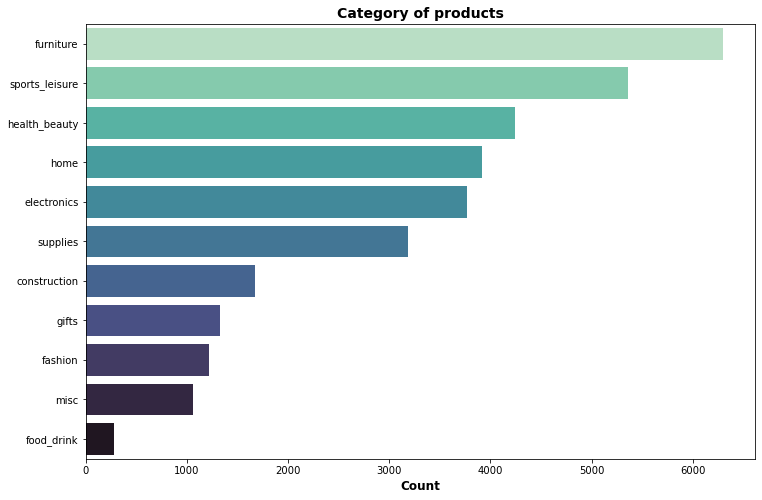

In [1006]:
df_products = prod_eng.replace({"product_category_name_english":
                                product_cat_dict})
fig = plt.figure(figsize=(12, 8))
ax = sns.countplot(y=df_products['product_category_name_english'],
                   palette='mako_r',
                   order=df_products['product_category_name_english']
                   .value_counts().index)
plt.title('Category of products', weight='bold', size=14)
plt.ylabel('')
plt.xlabel('Count', weight='bold', size=12)
plt.show()

The project is focused on customers segmentation, the detailed information about the products is not useful to us so we drop few features.

In [1007]:
features_useless = ["product_weight_g", "product_length_cm",
                    "product_height_cm", "product_width_cm",
                    "product_name_lenght", "product_description_lenght",
                    "product_photos_qty"]
all_products = df_products.drop(features_useless, axis=1)
all_products.head(2)

,product_category_name_english,product_id
0,health_beauty,e3e020af31d4d89d2602272b315c3f6e
1,health_beauty,c5d8079278e912d7e3b6beb48ecb56e8


#### 2.2 ORDERS ITEMS & ID

In [1008]:
orders_items = pd.merge(order_items, orders,
                        on='order_id')
orders_items.shape

(112650, 14)

In [1009]:
orders_items.groupby(by="order_status").sum()["order_item_id"]

order_status
approved            4
canceled          704
delivered      132036
invoiced          435
processing        455
shipped          1294
unavailable         8
Name: order_item_id, dtype: int64

Focus on delivered items only

In [1010]:
orders_items = orders_items[orders_items["order_status"] == "delivered"]
orders_items = orders_items.drop('order_status', axis=1)

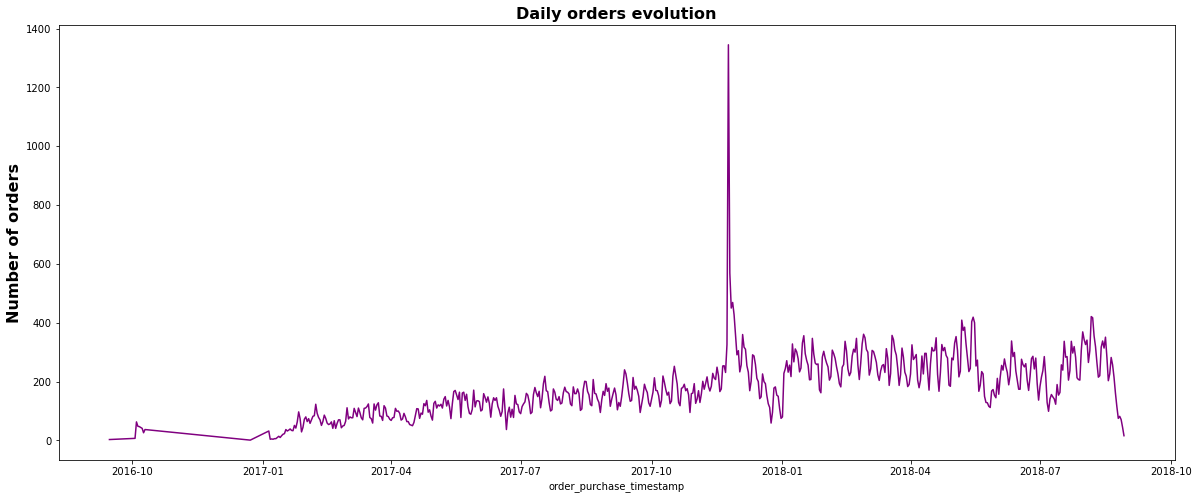

In [1011]:
fig = plt.figure(figsize=(20, 8))
daily_orders = orders_items.groupby(orders_items["order_purchase_timestamp"]
                                .astype('datetime64[ns]').dt.date)\
                                .count()["order_id"]
ax = daily_orders.plot(color="purple")
ax.set_ylabel("Number of orders", size=16, weight='bold')
plt.title("Daily orders evolution", weight='bold', size=16)
plt.show()

Daily sales are slightly increasing to 300 between the end of 2016 and then end of 2018 with a big spike reaching 1400 orders during one day in November 2017. This increase in orders is likely to represent "Black Friday".

In [1012]:
# Changing the data type for date columns
orders_items['order_purchase_timestamp'] = pd.to_datetime(
                                       orders_items['order_purchase_timestamp'])

# Extracting attributes for purchase date - Year and Month
orders_items['order_purchase_year'] = orders_items['order_purchase_timestamp']\
                                        .apply(lambda x: x.year)
orders_items['order_purchase_month'] = orders_items['order_purchase_timestamp']\
                                        .apply(lambda x: x.month)
orders_items['order_purchase_name_month'] = orders_items['order_purchase_timestamp']\
                                        .apply(lambda x: x.strftime('%b'))
orders_items['order_purchase_year_month'] = orders_items['order_purchase_timestamp']\
                                        .apply(lambda x: x.strftime('%Y%m'))
orders_items['order_purchase_date'] = orders_items['order_purchase_timestamp']\
                                        .apply(lambda x: x.strftime('%Y%m%d'))

In [1013]:
# Extracting attributes for purchase date - Day and Day of Week
orders_items['order_purchase_day'] = orders_items['order_purchase_timestamp']\
                                        .apply(lambda x: x.day)
orders_items['order_purchase_dayofweek'] = orders_items['order_purchase_timestamp']\
                                        .apply(lambda x: x.dayofweek)
orders_items['order_purchase_dayofweek_name'] =\
                                        orders_items['order_purchase_timestamp']\
                                        .apply(lambda x: x.strftime('%a'))

In [1014]:
orders_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_purchase_timestamp,order_approved_at,...,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_name_month,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,2017-09-13 09:45:35,...,2017-09-20 23:43:48,2017-09-29 00:00:00,2017,9,Sep,201709,20170913,13,2,Wed
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,2017-04-26 11:05:13,...,2017-05-12 16:04:24,2017-05-15 00:00:00,2017,4,Apr,201704,20170426,26,2,Wed
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,2018-01-14 14:48:30,...,2018-01-22 13:19:16,2018-02-05 00:00:00,2018,1,Jan,201801,20180114,14,6,Sun
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,2018-08-08 10:10:18,...,2018-08-14 13:32:39,2018-08-20 00:00:00,2018,8,Aug,201808,20180808,8,2,Wed
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,2017-02-04 14:10:13,...,2017-03-01 16:42:31,2017-03-17 00:00:00,2017,2,Feb,201702,20170204,4,5,Sat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,2018-04-25 04:11:01,...,2018-05-10 22:56:40,2018-05-18 00:00:00,2018,4,Apr,201804,20180423,23,0,Mon
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,2018-07-17 04:31:48,...,2018-07-23 20:31:55,2018-08-01 00:00:00,2018,7,Jul,201807,20180714,14,5,Sat
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,2017-10-24 17:14:25,...,2017-10-28 12:22:22,2017-11-10 00:00:00,2017,10,Oct,201710,20171023,23,0,Mon
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,2017-08-15 00:04:32,...,2017-08-16 21:59:40,2017-08-25 00:00:00,2017,8,Aug,201708,20170814,14,0,Mon


### GROWING BUSINESS

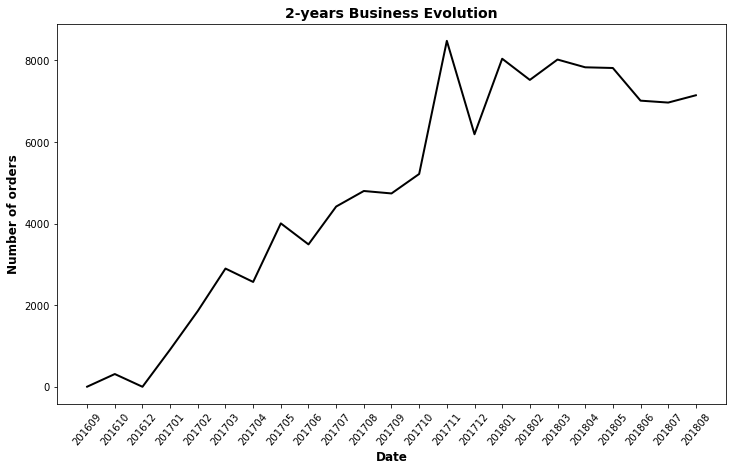

In [1015]:
fig = plt.figure(figsize=(12, 7))
sns.lineplot(data=orders_items['order_purchase_year_month']
             .value_counts().sort_index(),
             color='black', linewidth=2)
plt.title('2-years Business Evolution', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12, weight='bold')
plt.ylabel('Number of orders', fontsize=12, weight='bold')
plt.xticks(rotation=50)
plt.show()

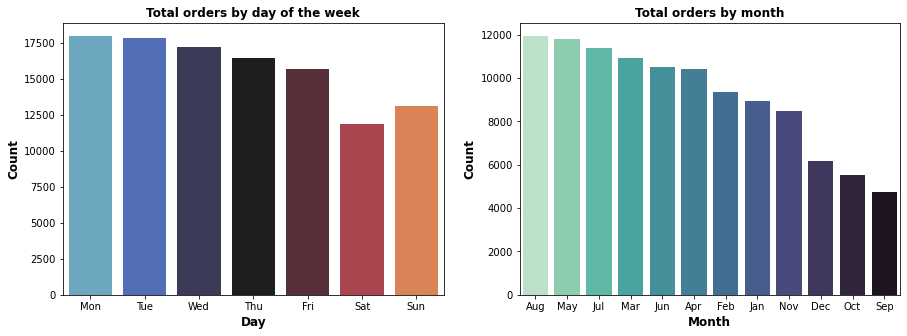

In [1016]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x=orders_items['order_purchase_dayofweek'],
              palette='icefire', ax=axes[0])
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0].set_xticklabels(weekday_label)
axes[0].set_title('Total orders by day of the week', weight='bold', size=12)
axes[0].set_xlabel('Day', weight='bold', size=12)
axes[0].set_ylabel('Count', weight='bold', size=12)

sns.countplot(x=orders_items['order_purchase_name_month'],
              palette='mako_r', ax=axes[1],
              order=orders_items['order_purchase_name_month']
              .value_counts().index)
axes[1].set_title('Total orders by month', weight='bold', size=12)
axes[1].set_xlabel('Month', weight='bold', size=12)
axes[1].set_ylabel('Count', weight='bold', size=12)

plt.show()

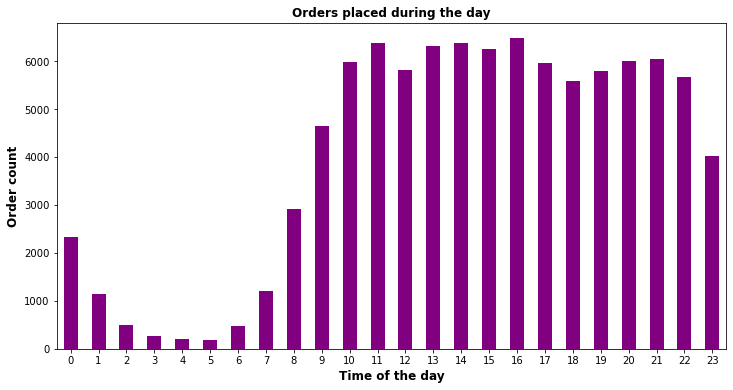

In [1017]:
orders_items.groupby(orders_items['order_purchase_timestamp'].dt.hour)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12, 6), kind="bar", color='purple',
          legend=False)
plt.title("Orders placed during the day", weight='bold')
plt.xlabel("Time of the day", weight='bold', size=12)
plt.ylabel("Order count", weight='bold', size=12)
plt.xticks(rotation=0)
plt.show()

### Price & payments

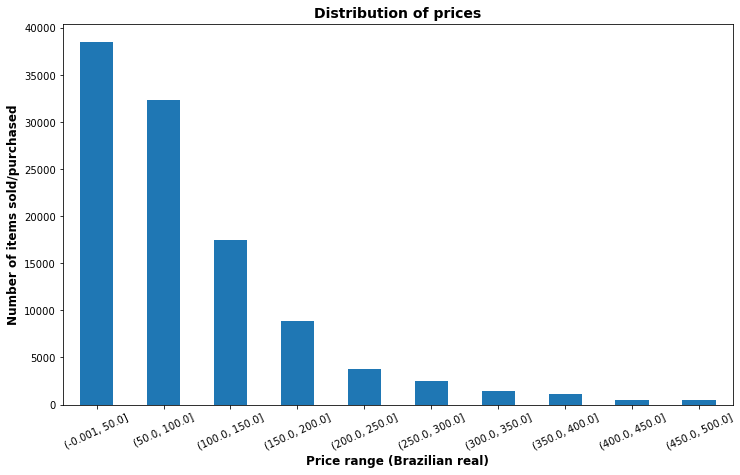

In [1018]:
fig = plt.figure(figsize=(12, 7))
plt.rcParams["figure.figsize"] = (15, 7)
res = orders_items['price'].value_counts(sort=False,
                                     bins=range(0, 550, 50)).plot.bar()
plt.title('Distribution of prices', fontsize=14, weight='bold')
plt.xlabel('Price range (Brazilian real)', fontsize=12, weight='bold')
plt.ylabel('Number of items sold/purchased', fontsize=12, weight='bold')
plt.xticks(rotation=25)
plt.show()

Most of the purchases prices on Olist are under 200 Brazilian real (~30 euros)

Most and least expensive items

In [1019]:
money = ['price', 'freight_value']
value = orders_items.groupby('order_id')[money]\
                .sum().sort_values(by='price', ascending=False).reset_index()
value.head(2).append(value.tail(2))

,order_id,price,freight_value
0,03caa2c082116e1d31e67e9ae3700499,13440.00,224.08
1,736e1922ae60d0d6a89247b851902527,7160.00,114.88
96476,3ee6513ae7ea23bdfab5b9ab60bffcb5,0.85,18.23
96477,6e864b3f0ec71031117ad4cf46b7f2a1,0.85,18.23


In [1020]:
orders_items['total_spent'] = orders_items['price'] + orders_items['freight_value']
orders_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_purchase_timestamp,order_approved_at,...,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_name_month,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,total_spent
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,2017-09-13 09:45:35,...,2017-09-29 00:00:00,2017,9,Sep,201709,20170913,13,2,Wed,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,2017-04-26 11:05:13,...,2017-05-15 00:00:00,2017,4,Apr,201704,20170426,26,2,Wed,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,2018-01-14 14:48:30,...,2018-02-05 00:00:00,2018,1,Jan,201801,20180114,14,6,Sun,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,2018-08-08 10:10:18,...,2018-08-20 00:00:00,2018,8,Aug,201808,20180808,8,2,Wed,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,2017-02-04 14:10:13,...,2017-03-17 00:00:00,2017,2,Feb,201702,20170204,4,5,Sat,218.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,2018-04-25 04:11:01,...,2018-05-18 00:00:00,2018,4,Apr,201804,20180423,23,0,Mon,343.40
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,2018-07-17 04:31:48,...,2018-08-01 00:00:00,2018,7,Jul,201807,20180714,14,5,Sat,386.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,2017-10-24 17:14:25,...,2017-11-10 00:00:00,2017,10,Oct,201710,20171023,23,0,Mon,116.85
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,2017-08-15 00:04:32,...,2017-08-25 00:00:00,2017,8,Aug,201708,20170814,14,0,Mon,64.71


In [1021]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 12))
# fig.suptitle("Price & Freight value distribution",
#              fontsize=18, weight='bold', size=20)

# sns.histplot(orders_items['price'], ax=axes[0, 0])
# axes[0, 0].set_xlabel("Price")
# axes[0, 0].set_ylabel("Frequency")

# sns.histplot(orders_items['freight_value'], ax=axes[1, 0])
# axes[1, 0].set_xlabel("freight_value")
# axes[1, 0].set_ylabel("Frequency")

# sns.histplot(np.log1p(orders_items['price']), ax=axes[0, 1])
# axes[0, 1].set_xlabel("Log {Price}")
# axes[0, 1].set_ylabel("Frequency")

# sns.histplot(np.log1p(orders_items['freight_value']), ax=axes[1, 1])
# axes[1, 1].set_xlabel("Log {Freight_value}")
# axes[1, 1].set_ylabel("Frequency")

# plt.show()

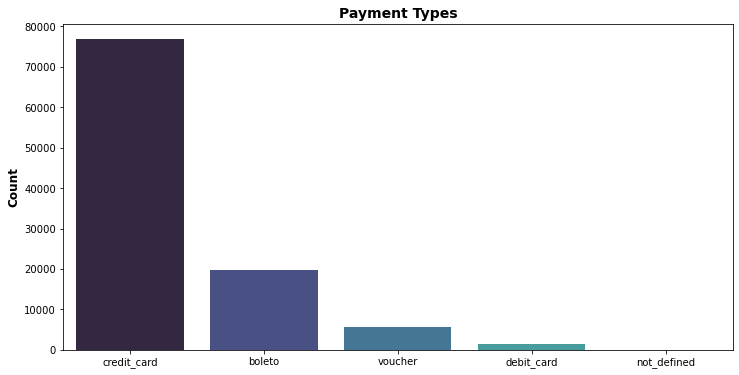

In [1022]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x=order_payments['payment_type'], palette='mako')
plt.title('Payment Types', weight='bold', size=14)
plt.ylabel('Count', weight='bold', size=12)
plt.xlabel('')
plt.show()

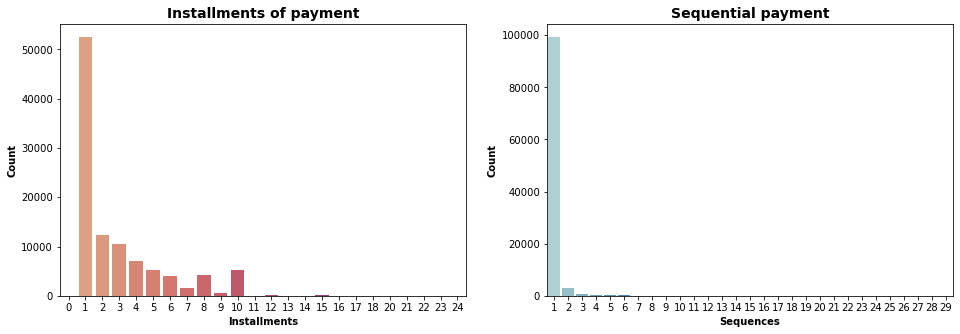

In [1023]:
f, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = sns.countplot(x=order_payments['payment_installments'],
                   palette='flare', ax=axes[0])
axes[0].set_title('Installments of payment', weight='bold', size=14)
axes[0].set_ylabel('Count', weight='bold')
axes[0].set_xlabel('Installments', weight='bold')

ax = sns.countplot(x=order_payments['payment_sequential'], palette='icefire',
                   ax=axes[1])
axes[1].set_title('Sequential payment', weight='bold', size=14)
axes[1].set_ylabel('Count', weight='bold')
axes[1].set_xlabel('Sequences', weight='bold')
plt.show()

#### REVIEWS of PRODUCTS by CUSTOMERS

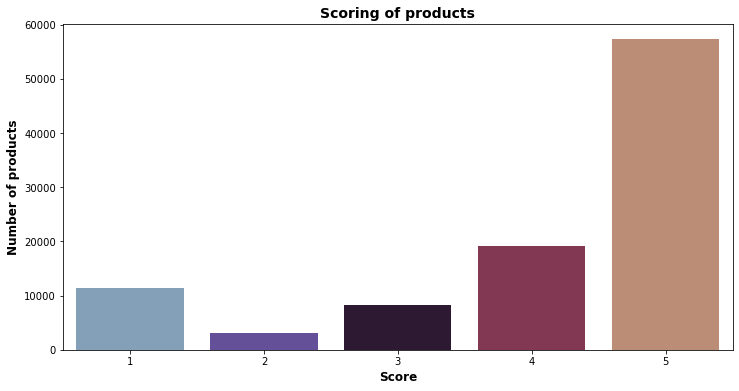

In [1024]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x=order_reviews['review_score'], palette='twilight')
plt.title('Scoring of products', weight='bold', size=14)
plt.ylabel('Number of products', weight='bold', size=12)
plt.xlabel('Score', weight='bold', size=12)
plt.show()

### FOCUS ON CUSTOMERS

#### GEOGRAPHICAL DISTRIBUTION OF CUSTOMERS

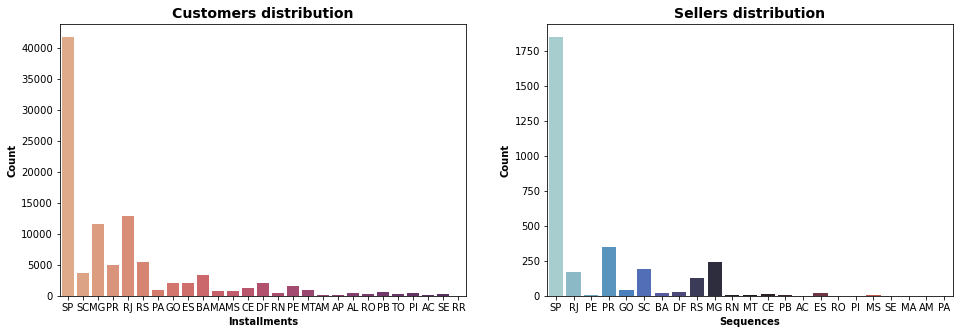

In [1025]:
f, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = sns.countplot(x=customers['customer_state'],
                   palette='flare', ax=axes[0])                  
axes[0].set_title('Customers distribution', weight='bold', size=14)
axes[0].set_ylabel('Count', weight='bold')
axes[0].set_xlabel('Installments', weight='bold')

ax = sns.countplot(x=sellers['seller_state'], palette='icefire', ax=axes[1])
axes[1].set_title('Sellers distribution', weight='bold', size=14)
axes[1].set_ylabel('Count', weight='bold')
axes[1].set_xlabel('Sequences', weight='bold')
plt.show()

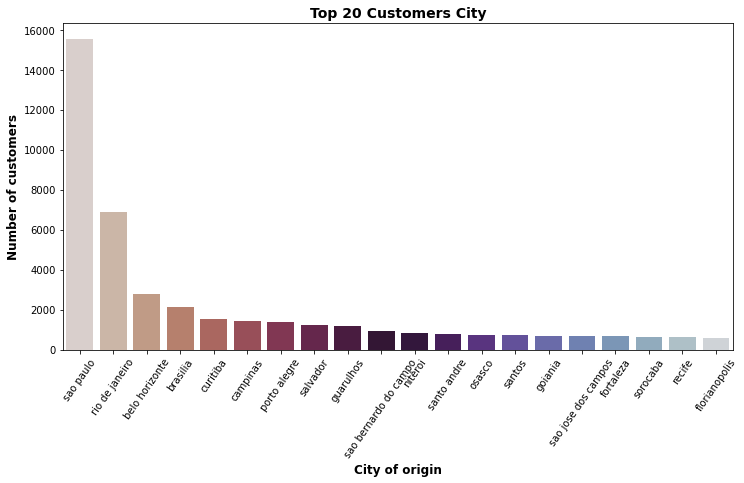

In [1026]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x=customers['customer_city'], palette='twilight_r',
                   order=customers['customer_city']
                   .value_counts().iloc[:20].index)
plt.title('Top 20 Customers City', weight='bold', size=14)
plt.ylabel('Number of customers', weight='bold', size=12)
plt.xticks(rotation=55)
plt.xlabel('City of origin', weight='bold', size=12)
plt.show()

In [1027]:
orders_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_purchase_timestamp,order_approved_at,...,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_name_month,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,total_spent
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,2017-09-13 09:45:35,...,2017-09-29 00:00:00,2017,9,Sep,201709,20170913,13,2,Wed,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,2017-04-26 11:05:13,...,2017-05-15 00:00:00,2017,4,Apr,201704,20170426,26,2,Wed,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,2018-01-14 14:48:30,...,2018-02-05 00:00:00,2018,1,Jan,201801,20180114,14,6,Sun,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,2018-08-08 10:10:18,...,2018-08-20 00:00:00,2018,8,Aug,201808,20180808,8,2,Wed,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,2017-02-04 14:10:13,...,2017-03-17 00:00:00,2017,2,Feb,201702,20170204,4,5,Sat,218.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,2018-04-25 04:11:01,...,2018-05-18 00:00:00,2018,4,Apr,201804,20180423,23,0,Mon,343.40
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,2018-07-17 04:31:48,...,2018-08-01 00:00:00,2018,7,Jul,201807,20180714,14,5,Sat,386.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,2017-10-24 17:14:25,...,2017-11-10 00:00:00,2017,10,Oct,201710,20171023,23,0,Mon,116.85
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,2017-08-15 00:04:32,...,2017-08-25 00:00:00,2017,8,Aug,201708,20170814,14,0,Mon,64.71


Let's merge customers with orders_items

In [1028]:
cust_order = pd.merge(orders_items, customers,
                        on='customer_id')
cust_order.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_purchase_timestamp,order_approved_at,...,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,total_spent,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,2017-09-13 09:45:35,...,201709,20170913,13,2,Wed,72.19,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,2017-04-26 11:05:13,...,201704,20170426,26,2,Wed,259.83,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP


#### RECENCY

In [1029]:
latestdate = np.max(cust_order['order_purchase_timestamp'])
print(latestdate)

2018-08-29 15:00:37


In [1030]:
cust_order['recency'] = cust_order['order_purchase_timestamp'].apply(lambda x: (latestdate - x).days)
custom_order = cust_order.drop(['order_purchase_timestamp'], axis=1)
custom_order.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_approved_at,order_delivered_carrier_date,...,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,total_spent,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,recency
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,2017-09-13 09:45:35,2017-09-19 18:34:16,...,20170913,13,2,Wed,72.19,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,350
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 11:05:13,2017-05-04 14:35:00,...,20170426,26,2,Wed,259.83,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,490
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:48:30,2018-01-16 12:36:48,...,20180114,14,6,Sun,216.87,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,227
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:10:18,2018-08-10 13:28:00,...,20180808,8,2,Wed,25.78,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,21
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 14:10:13,2017-02-16 09:46:09,...,20170204,4,5,Sat,218.04,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,571


In [1031]:
# grouping by customer_unique_id 
ord_recency = custom_order.groupby("customer_unique_id")["recency"].min()
ord_recency

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    111
0000b849f77a49e4a4ce2b2a4ca5be3f    114
0000f46a3911fa3c0805444483337064    536
0000f6ccb0745a6a4b88665a16c9f078    320
0004aac84e0df4da2b147fca70cf8255    287
                                   ... 
fffcf5a5ff07b0908bd4e2dbc735a684    446
fffea47cd6d3cc0a88bd621562a9d061    261
ffff371b4d645b6ecea244b27531430a    567
ffff5962728ec6157033ef9805bacc48    118
ffffd2657e2aad2907e67c3e9daecbeb    483
Name: recency, Length: 93358, dtype: int64

#### FREQUENCY

In [1032]:
frequency = custom_order.groupby("customer_unique_id")["order_id"].size()
frequency

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_id, Length: 93358, dtype: int64

#### MONETARY

In [1033]:
monetary = custom_order.groupby("customer_unique_id")["total_spent"].sum()
monetary

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2     141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      27.19
0000f46a3911fa3c0805444483337064      86.22
0000f6ccb0745a6a4b88665a16c9f078      43.62
0004aac84e0df4da2b147fca70cf8255     196.89
                                     ...   
fffcf5a5ff07b0908bd4e2dbc735a684    2067.42
fffea47cd6d3cc0a88bd621562a9d061      84.58
ffff371b4d645b6ecea244b27531430a     112.46
ffff5962728ec6157033ef9805bacc48     133.69
ffffd2657e2aad2907e67c3e9daecbeb      71.56
Name: total_spent, Length: 93358, dtype: float64

In [1034]:
df_rfm = pd.merge(pd.merge(ord_recency, monetary,on='customer_unique_id'), frequency,on='customer_unique_id')
df_rfm.rename(columns={"order_id": "frequency"}, inplace=True)
df_rfm.rename(columns={"total_spent": "monetary"}, inplace=True)
df_rfm.reset_index()
df_rfm.round()

,recency,monetary,frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,142.0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,114,27.0,1
0000f46a3911fa3c0805444483337064,536,86.0,1
0000f6ccb0745a6a4b88665a16c9f078,320,44.0,1
0004aac84e0df4da2b147fca70cf8255,287,197.0,1
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,2067.0,2
fffea47cd6d3cc0a88bd621562a9d061,261,85.0,1
ffff371b4d645b6ecea244b27531430a,567,112.0,1


In [1035]:
print(df_rfm['frequency'].value_counts(normalize=True) * 100)

1     87.564001
2      9.422867
3      1.763105
4      0.665181
5      0.258146
6      0.203518
7      0.048202
8      0.017138
11     0.011783
10     0.011783
9      0.010711
12     0.009640
14     0.003213
15     0.003213
13     0.002142
20     0.002142
18     0.001071
21     0.001071
24     0.001071
Name: frequency, dtype: float64


87% of the customers have only made 1 purchase.

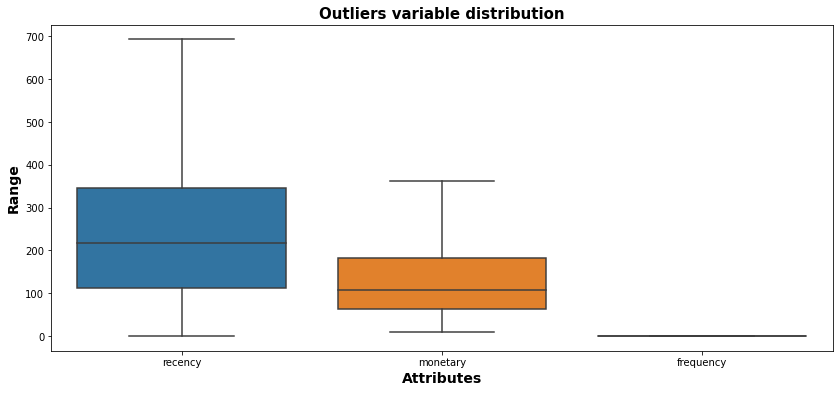

In [1036]:
fig = plt.figure(figsize=(14,6))
ax = sns.boxplot(data=df_rfm, showfliers = False)
ax.axes.set_title("Outliers variable distribution", fontsize=15, weight = "bold")
ax.set_xlabel("Attributes", fontsize=14, weight = "bold")
ax.set_ylabel("Range", fontsize=14, weight = "bold")
ax.tick_params(labelsize=10)
plt.show()

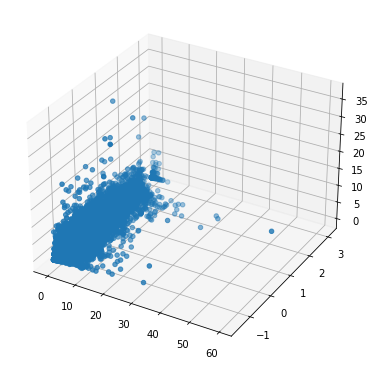

In [1037]:

rfm_norm = preprocessing.scale(df_rfm)
rfm_norm = pd.DataFrame(data=rfm_norm, columns=["recency", "frequency", "monetary"])

fig = plt.figure(figsize=(8, 10))
x = rfm_norm.recency
y = rfm_norm.frequency
z = rfm_norm.monetary

ax = fig.add_subplot(3, 3, (1, 6), projection="3d")
ax.scatter(y, x, z)

plt.show()

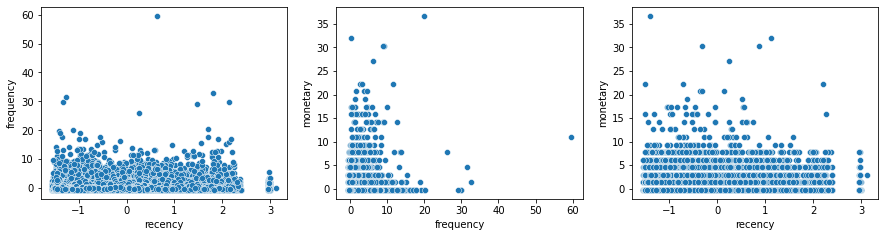

In [961]:
fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(331)
sns.scatterplot(data=rfm_norm, y="frequency", x="recency", ax=ax)

ax = fig.add_subplot(332)
sns.scatterplot(data=rfm_norm, x="frequency", y="monetary", ax=ax)

ax = fig.add_subplot(333)
sns.scatterplot(data=rfm_norm, x="recency", y="monetary", ax=ax)
plt.show()

In [962]:
# rfm_norm = rfm_norm[(rfm_norm.frequency<40)]

Now we split the metrics into segments using quantiles.<br>
We will assign a score from 1 to 4 to Recency and Monetary :<br>
1 is the highest value (lowest recency and highest monetary), and 4 is the lowest value (highest recency and lowest monetary.<br>
As 87% of the customers only bought once, we assign 2 to frequency if they bought more than once (and default 1).
A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

In [1038]:
df_rfm_copy = df_rfm.copy()
df_rfm_copy['R_percentile'] = df_rfm_copy['recency'].rank(pct=True,ascending=False)
df_rfm_copy['R_score'] = pd.qcut(df_rfm_copy['R_percentile'], 4, labels=range(4,0,-1))

df_rfm_copy['F_score'] = df_rfm_copy['frequency'].apply(lambda x: '1' if x==1 else '2')

df_rfm_copy['M_percentile'] = df_rfm_copy['monetary'].rank(pct=True,ascending=True)
df_rfm_copy['M_score'] = pd.qcut(df_rfm_copy['M_percentile'], 4, labels=range(4,0,-1))

df_rfm_copy['rfm_score'] = df_rfm_copy['R_score'].astype(str) + df_rfm_copy['F_score'].astype(str) + df_rfm_copy['M_score'].astype(str)
df_rfm_copy

,recency,monetary,frequency,R_percentile,R_score,F_score,M_percentile,M_score,rfm_score
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,141.90,1,0.758408,1,1,0.634659,2,112
0000b849f77a49e4a4ce2b2a4ca5be3f,114,27.19,1,0.747927,2,1,0.021707,4,214
0000f46a3911fa3c0805444483337064,536,86.22,1,0.035037,4,1,0.394562,3,413
0000f6ccb0745a6a4b88665a16c9f078,320,43.62,1,0.286371,3,1,0.122587,4,314
0004aac84e0df4da2b147fca70cf8255,287,196.89,1,0.336613,3,1,0.780003,1,311
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,2067.42,2,0.121982,4,2,0.998243,1,421
fffea47cd6d3cc0a88bd621562a9d061,261,84.58,1,0.414126,3,1,0.385034,3,313
ffff371b4d645b6ecea244b27531430a,567,112.46,1,0.015125,4,1,0.519013,2,412


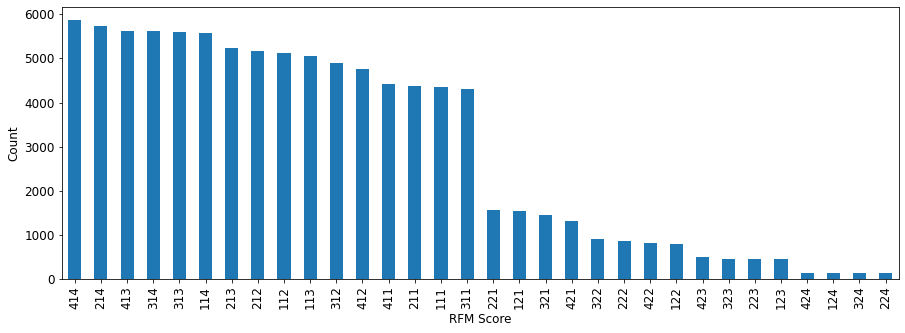

In [1039]:
ax = df_rfm_copy['rfm_score'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

We attribute a score from 1 to 4:
Recency = 1: Short time since last purchase
Recency = 4: Long time since last purchase
Frequency = 1: One single purchase
Frequency = 2: Multiple purchases
Monetary = 1: High value purchase
Monetary = 4: Low value purchase

In [1040]:
segt_map = {
    r'[1-2]2[1-2]': 'Champions',
    r'[1-2]1[1-2]': 'Big Spenders',
    r'[1-2][1-2][3-4]': 'To motivate',
    r'[4][1-2][1-2]': 'Sleepy big spenders',
    r'[3][1-2][1-2]': 'Needs reminder',
    r'[3-4][1-2][3-4]': 'Sleepy cheap spenders',
    }

df_rfm_copy['Segment'] = df_rfm_copy['rfm_score'].replace(segt_map, regex=True)
df_rfm_copy['Segment'] = [x for x in df_rfm_copy['Segment']]
rfm_attr = pd.concat([df_rfm_copy['rfm_score'], df_rfm_copy['Segment']], axis=1)
rfm_attr.to_csv('attributes.csv')
rfm_attr.head(5)

,rfm_score,Segment
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,112,Big Spenders
0000b849f77a49e4a4ce2b2a4ca5be3f,214,To motivate
0000f46a3911fa3c0805444483337064,413,Sleepy cheap spenders
0000f6ccb0745a6a4b88665a16c9f078,314,Sleepy cheap spenders
0004aac84e0df4da2b147fca70cf8255,311,Needs reminder


__Champions__: Bought recently, more than once and spend "big" money

__Big spenders__: Bought recently, only once but spend "big" money

__Needs reminder__: Bought a while ago, once or more and spent "big" money

__Sleepy big spenders__: Bought a long time ago, once or more but spent "big money"

__To motivate__:  Bought recently, once or more with moderate spending

__Sleepy cheap spenders__: Bought long time ago, once or more with moderate spending

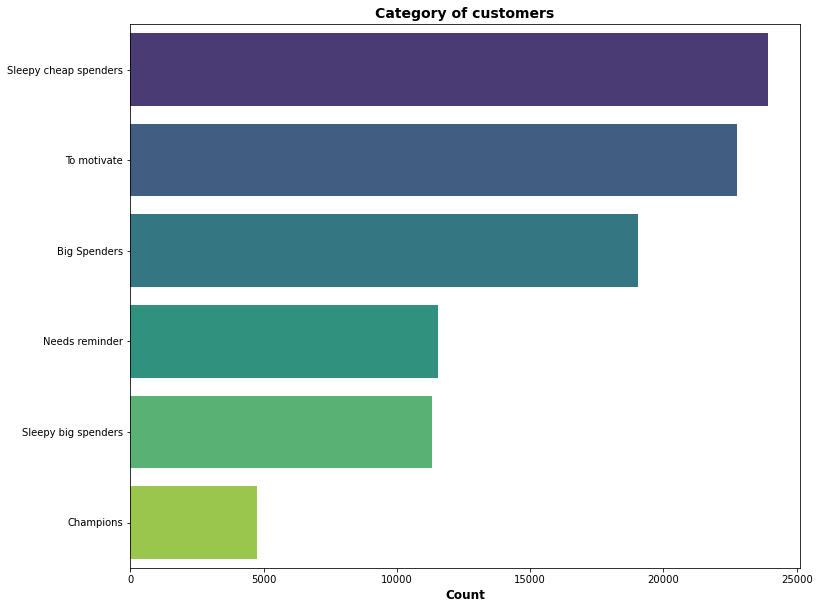

In [1041]:
chop = rfm_attr['Segment'].value_counts().sort_values(ascending=True)
fig = plt.figure(figsize=(12, 10))
ax = sns.countplot(y=rfm_attr['Segment'],
                   palette='viridis',
                   order=rfm_attr['Segment']
                   .value_counts().index)

plt.title('Category of customers', weight='bold', size=14)
plt.ylabel('')
plt.xlabel('Count', weight='bold', size=12)
plt.show()

### K Means

In [1042]:
from sklearn import cluster, metrics

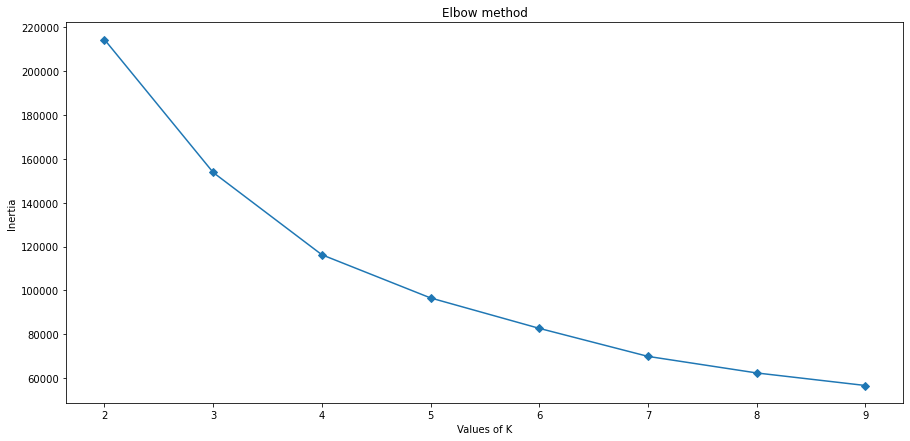

In [1043]:
kmeans = cluster.KMeans(n_clusters=5, max_iter=50).fit(rfm_norm)
clt = []
clusters_range = range(2, 10, 1)
for num_clusters in clusters_range:
    kmeans = cluster.KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_norm)
    
    clt.append(kmeans.inertia_)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.plot(range(2, 10), ssd, marker='D')
plt.show()

In [884]:
k_means_silhouette = []
from sklearn.metrics import silhouette_samples, silhouette_score
for n_clusters in clusters_range:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = cluster.KMeans(n_clusters=n_clusters, max_iter=50)
    kmeans.fit(rfm_norm)
    
    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(rfm_norm, cluster_labels)
    k_means_silhouette.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,2))

For n_clusters = 2 The average silhouette_score is : 0.37
For n_clusters = 3 The average silhouette_score is : 0.41
For n_clusters = 4 The average silhouette_score is : 0.43
For n_clusters = 5 The average silhouette_score is : 0.46
For n_clusters = 6 The average silhouette_score is : 0.4
For n_clusters = 7 The average silhouette_score is : 0.41
For n_clusters = 8 The average silhouette_score is : 0.41
For n_clusters = 9 The average silhouette_score is : 0.42


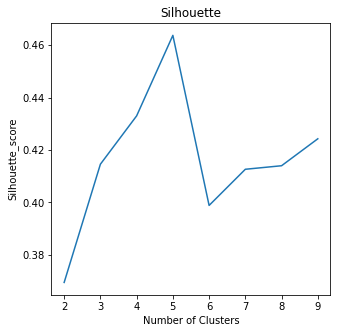

In [885]:
plt.figure(figsize=(5,5))
plt.plot(clusters_range, k_means_silhouette)
plt.title('Silhouette')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette_score') #within cluster sum of squares
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.36994610292743946
For n_clusters = 3 The average silhouette_score is : 0.4145404390226682
For n_clusters = 4 The average silhouette_score is : 0.4330000803347069
For n_clusters = 5 The average silhouette_score is : 0.4634937517766538
For n_clusters = 6 The average silhouette_score is : 0.39922671129975623
For n_clusters = 7 The average silhouette_score is : 0.41265625957386526
For n_clusters = 8 The average silhouette_score is : 0.4140029188074479
For n_clusters = 9 The average silhouette_score is : 0.4192799707654733


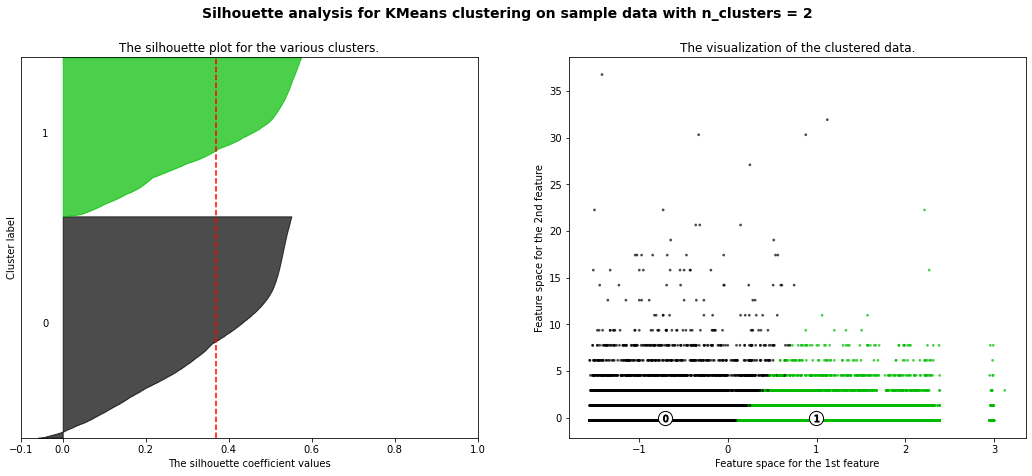

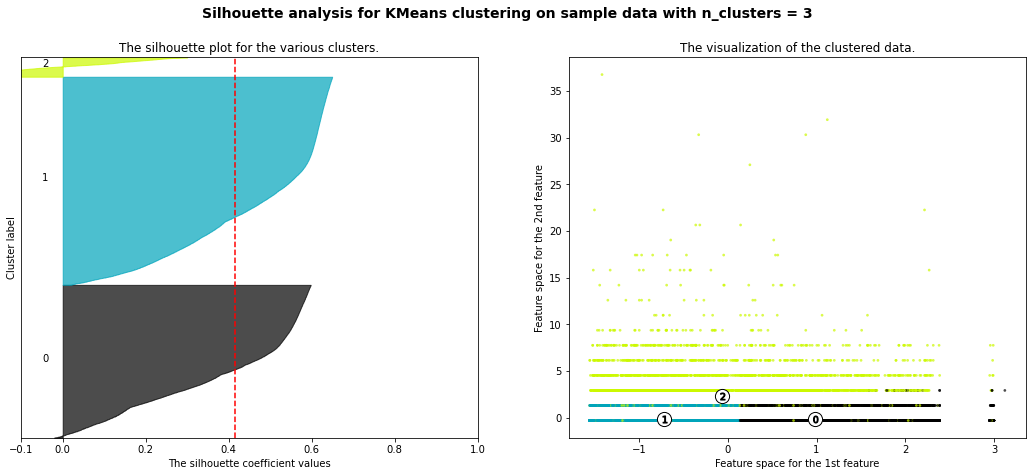

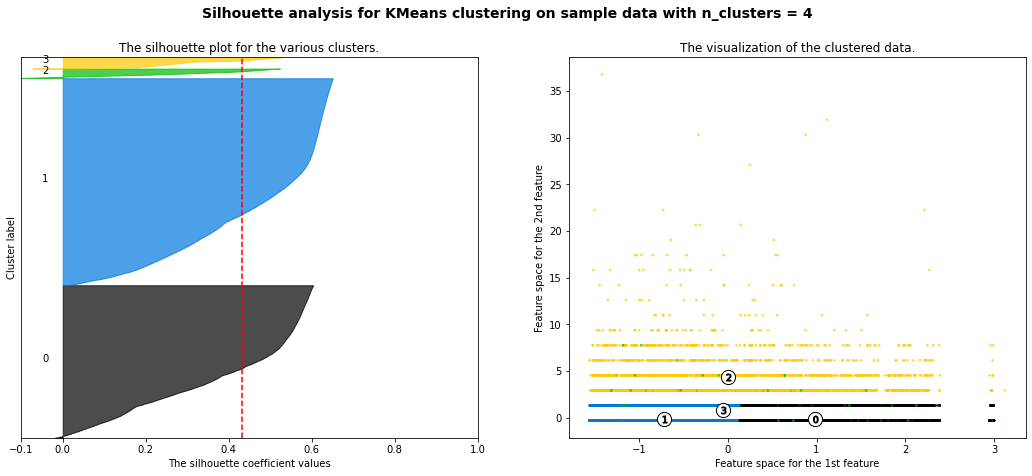

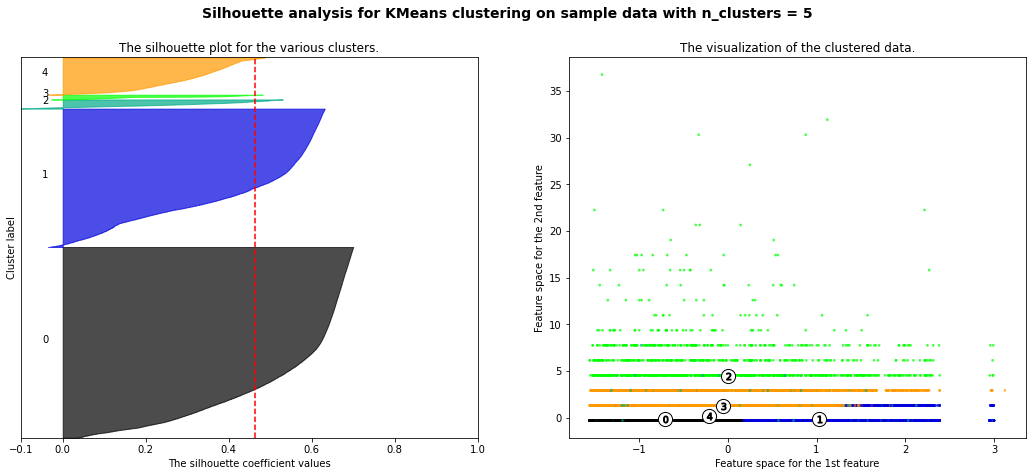

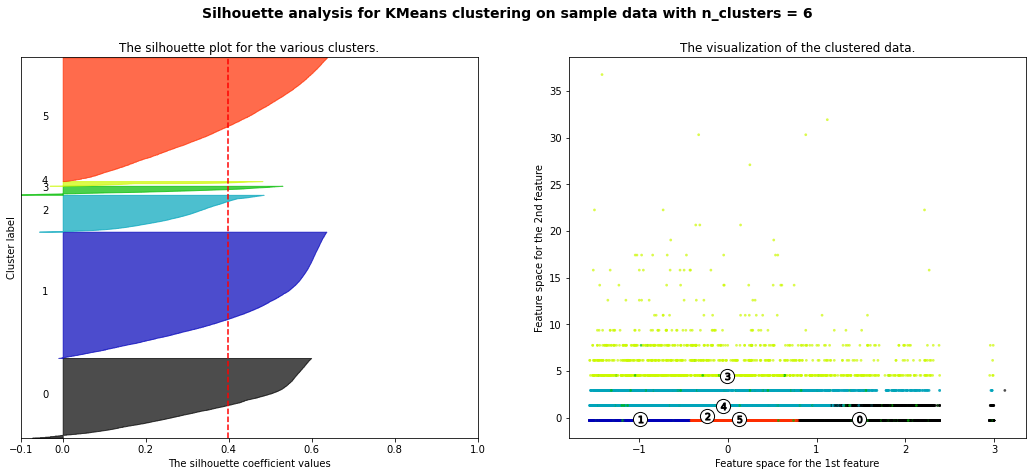

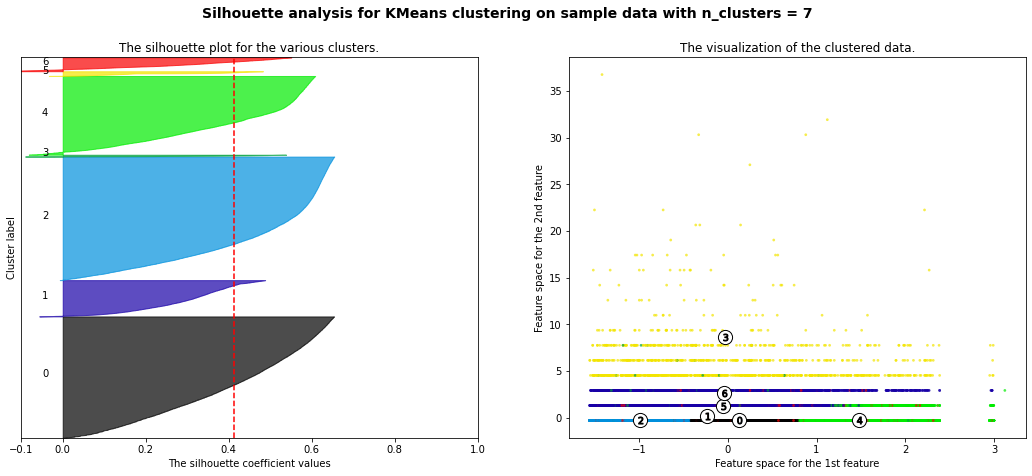

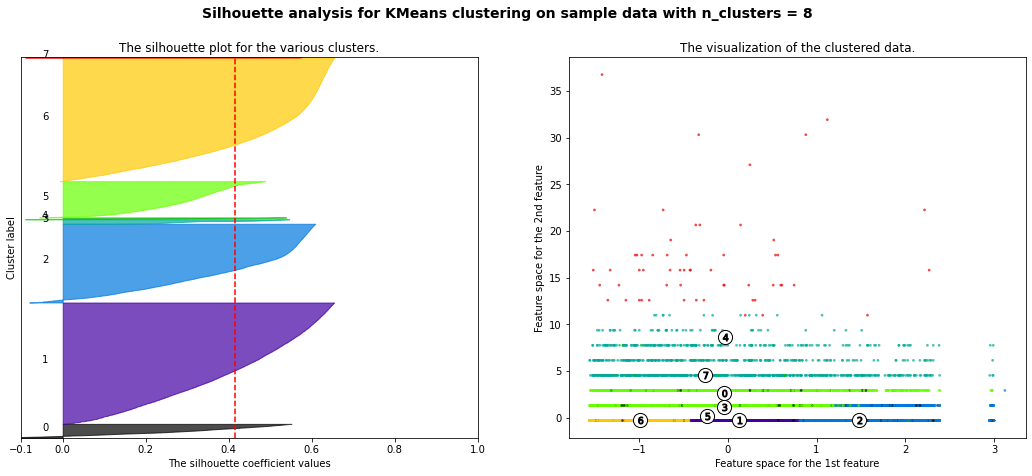

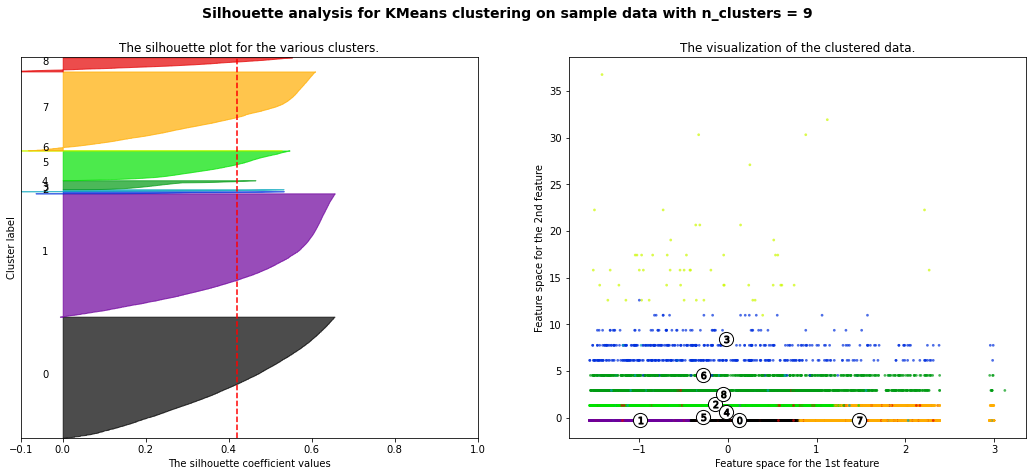

In [982]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(rfm_norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm_norm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(rfm_norm, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(rfm_norm['recency'], rfm_norm['monetary'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

C:\Users\steph\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\steph\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\steph\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\steph\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\steph\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\steph\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: Future

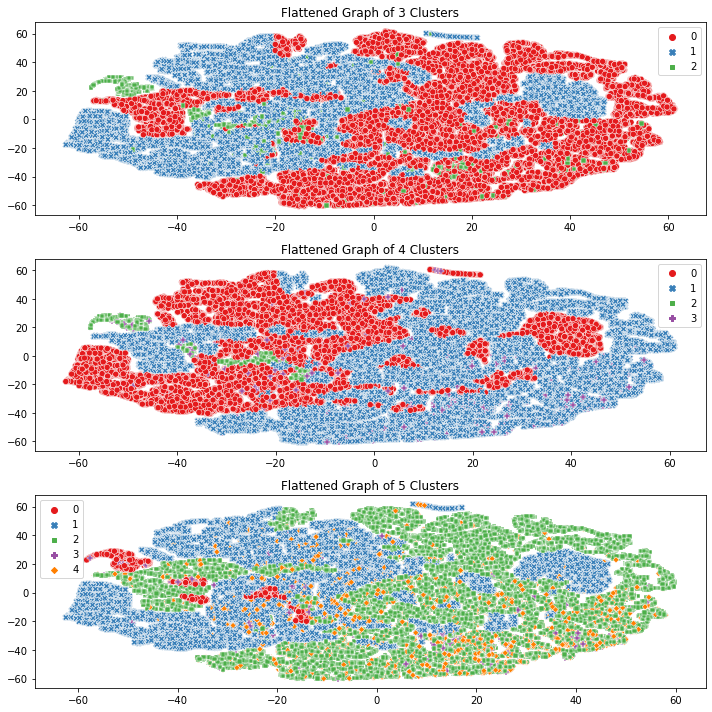

In [1044]:
def kmeans(rfm_norm, clusters_number, df_rfm):
    
    kmeans = cluster.KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(rfm_norm)
    
# Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=42)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(rfm_norm, 3, df_rfm)
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(rfm_norm, 4, df_rfm)
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(rfm_norm, 5, df_rfm)
plt.tight_layout()

### HDBSCAN

HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications with Noise. Performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN), and be more robust to parameter selection.

In [972]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=15, metric='euclidean')
clusterer.fit(df_rfm[['recency', 'frequency', 'monetary']])
df_rfm['Cluster'] = pd.Series(clusterer.labels_, index=df_rfm.index)
df_rfm.head(50)

,recency,monetary,frequency,Cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,141.90,1,5
0000b849f77a49e4a4ce2b2a4ca5be3f,114,27.19,1,5
0000f46a3911fa3c0805444483337064,536,86.22,1,5
0000f6ccb0745a6a4b88665a16c9f078,320,43.62,1,5
0004aac84e0df4da2b147fca70cf8255,287,196.89,1,5
0004bd2a26a76fe21f786e4fbd80607f,145,166.98,1,5
00050ab1314c0e55a6ca13cf7181fecf,131,35.38,1,5
00053a61a98854899e70ed204dd4bafe,182,419.18,2,5
0005e1862207bf6ccc02e4228effd9a0,542,150.12,1,5


In [973]:
len(df_rfm['Cluster'].unique())-1

6

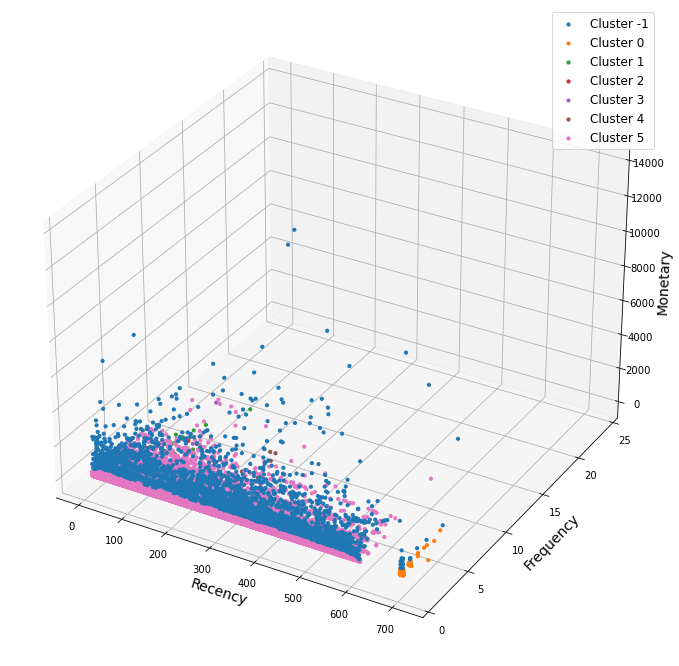

In [975]:
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.colors as mcolors
fig = plt.figure(figsize=(18,12))
dx = fig.add_subplot(111, projection='3d')

for i in range(-1,len(df_rfm['Cluster'].unique())-1):
    dx.scatter(df_rfm[df_rfm.Cluster == i].recency,
                     df_rfm[df_rfm.Cluster == i].frequency,
                     df_rfm[df_rfm.Cluster == i].monetary,
                     label = 'Cluster ' + str(i),
                     s=10, alpha=1.0)
dx.set_xlabel('Recency', fontsize=14)
dx.set_ylabel('Frequency', fontsize=14)
dx.set_zlabel('Monetary', fontsize=14)
dx.legend(fontsize=12)
plt.show()

In [976]:
pd.Series(clusterer.labels_).value_counts()

 5    89323
-1     3342
 0      229
 4      186
 1      112
 2       92
 3       74
dtype: int64